# import

In [135]:
import warnings
warnings.simplefilter('ignore')

import os
import gc 
import sys
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb 

from tqdm import tqdm
from collections import defaultdict
from scipy.spatial import distance
from multiprocessing import cpu_count

from sklearn.model_selection import StratifiedKFold, KFold 
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score

# settings

In [22]:
pd.options.display.max_columns = None

In [23]:
PATH = os.path.join('..', 'data')

In [43]:
NFOLDS = 11

SEED = 2019

# read

In [49]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

In [50]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

In [51]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,8.7625,-15.6305,18.8766,11.2864,11.8362,13.3680,-31.9891,12.1776,8.7714,17.2011,16.8508,13.0534,14.4069,-4.8525,7.3213,-0.5259,16.6365,19.3036,6.4129,-5.3948,9.3269,11.9314,-3.5750,-0.7706,0.8705,6.9282,2.8914,5.9744,17.4851,5.0125,-1.4230,33.3401,0.8018,-4.7906,30.2708,26.8339,21.7205,7.3075,14.0810,3.1192,17.4265,9.4883,16.9060,14.5117,10.0276,-0.9706,20.4588,4.7945,20.4160,13.1633,7.9307,-7.6509,7.0834,15.2324,10.1416,5.9156,-0.5775,5.7600,30.3238,2.1251,1.8585,-9.2198,17.3089,30.9548,1.4918,12.8721,3.4902,8.2856,11.9794,14.0176,15.0763,3.7662,6.0426,4.4243,14.1799,2.0921,1.5493,3.2206,0.0172,-6.6602,8.4785,42.0248,11.4164,0.4564,9.4006,0.9685,12.4929,14.1240,4.0388,-4.4442,16.6684,12.5380,0.9205,10.5998,7.5147,-4.1748,-0.4824,10.5267,17.7547,-6.5226,-2.5502,-5.1547,-2.1246,19.8319,13.0752,9.2275,3.0213,11.6793,-11.6827,4.1017,5.2954,18.7741,9.8892,7.5219,14.9745,18.9880,1.0842,11.9125,-4.5103,16.1361,11.0067,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,-1.5536,10.0309,3.1337,10.5742,11.7664,2.1782,-41.1924,13.5322,-17.3834,6.3806,12.5589,11.6887,25.3930,1.5776,6.8481,8.7348,16.4239,21.7056,6.9345,1.6678,9.5249,5.3383,-18.7083,1.3382,-1.7401,5.8398,3.1051,4.4307,16.0005,5.0306,-7.3365,12.2806,0.6992,-0.7772,21.5123,6.7803,18.1896,6.9388,22.1336,6.3755,13.1525,1.9772,14.0406,6.6904,9.9732,-11.5679,20.4525,9.4951,9.6343,8.1252,2.6059,-17.4201,7.1848,15.3484,10.6522,5.9897,0.3392,10.3516,29.8204,1.9998,-1.4166,-1.7257,15.4712,35.6020,1.6570,13.0783,2.7752,6.4986,4.6835,13.7963,17.7261,1.7375,5.5689,3.6609,8.9725,4.1159,1.0693,2.0234,8.2760,-6.8610,0.2780,17.0488,11.6704,3.1215,8.5093,5.6367,12.0099,14.2372,-

# Normalized

In [52]:
df = pd.concat([train, test], axis=0)

In [53]:
for c in df.columns[2:]:
    df[c] = (df[c] - df[c].min()) / (df[c].max() - df[c].min())

In [54]:
df.describe()

,target,var_0,var_1,var_10,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_11,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_12,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_13,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_14,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_15,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_16,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_17,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_18,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_19,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_2,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_3,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_4,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_5,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_6,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_7,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_8,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_9,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99
count,200000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,4000

In [55]:
df.head()

,ID_code,target,var_0,var_1,var_10,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_11,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_12,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_13,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_14,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_15,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_16,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_17,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_18,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_19,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_2,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_3,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_4,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_5,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_6,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_7,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_8,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_9,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99
0,train_0,0.0,0.394711,0.324824,0.596863,0.762980,0.468268,0.575249,0.371640,0.695052,0.814813,0.598691,0.446209,0.376134,0.711731,0.676400,0.395242,0.600316,0.582141,0.182941,0.387989,0.445372,0.506447,0.519268,0.391345,0.669532,0.468549,0.379924,0.310992,0.477752,0.328803,0.511474,0.237730,0.609783,0.418142,0.455886,0.456965,0.232357,0.604336,0.417368,0.699521,0.409553,0.799844,0.653778,0.610643,0.759929,0.549759,0.625954,0.569732,0.650336,0.272817,0.654589,0.425425,0.511263,0.673634,0.556649,0.259168,0.471477,0.659573,0.535530,0.572797,0.546183,0.558938,0.442399,0.594172,0.613311,0.335113,0.309953,0.436973,0.519756,0.308137,0.333029,0.308967,0.347908,0.339334,0.838157,0.259545,0.368587,0.624072,0.735866,0.434280,0.497627,0.333810,0.347898,0.499689,0.616911,0.463174,0.267605,0.393620,0.560712,0.435670,0.436803,0.294094,0.378377,0.405663,0.543385,0.639256,0.705287,0.799861,0.600263,0.393106,0.528213,0.476595,0.901957,0.537807,0.342943,0.568958,0.448173,0.510471,0.291973,0.678981,0.412164,0.320222,0.564556,0.568059,0.425701,0.444895,0.396726,0.330764,0.577386,0.368293,0.482137,0.603841,0.424169,0.601423,0.388041,0.683647,0.614700,0.320632,0.548632,0.403144,0.700837,0.450915,0.687248,0.304304,0.616714,0.550670,0.562163,0.451740,0.589446,0.724179,0.488978,0.546391,0.234790,0.489569,0.518249,0.267325,0.467301,0.531460,0.791101,0.572221,0.374227,0.461801,0.554261,0.323233,0.338138,0.466751,0.684845,0.465762,0.669817,0.708271,0.598650,0.519677,0.743571,0.799853,0.522032,0.687473,0.322034,0.467013,0.578688,0.474463,0.440058,0.632575,0.227822,0.659338,0.501389,0.344031,0.678984,0.622742,0.225303,0.270395,0.653124,0.394346,0.606844,0.527463,0.473750,0.558151,0.531146,0.596173,0.412696,0.307976,0.247420,0.452511,0.264189,0.411068,0.370965,0.744218,0.599642,0.386973,0.492325,0.536638,0.317578
1,train_1,0.0,0.511048,0.428639,0.519254,0.412378,0.303732,0.724402,0.583084,0.725562,0.291584,0.445444,0.727394,0.222880,0.295536,0.789061,0.553910,0.645661,0.715168,0.511356,0.552543,0.586011,0.550210,0.443862,0.421429,0.678840,0.476660,0.546430,0.290542,0.697084,0.562982,0.325525,0.508746,0.777446,0.580878,0.583121,0.494474,0.508937,0.529591,0.246830,0.296765,0.573598,0.714602,0.424080,0.305740,0.515922,0.414609,0.634466,0.333922,0.523578,0.574872,0.173409,0.476434,0.497078,0.783097,0.424575,0.800907,0.623910,0.410147,0.223730,0.703199,0.709618,0.578976,0.444519,0.242622,0.575914,0.345420,0.400059,0.531418,0.490332,0.766215,0.524610,0.681175,0.368220,0.655976,0.490642,

In [95]:
train = df[df['target'].notnull()]
test = df[df['target'].isnull()]

In [154]:
train['mean_l1_distance_from_0'] = 0
train['mean_l1_distance_from_1'] = 0
test['mean_l1_distance_from_0'] = 0
test['mean_l1_distance_from_1'] = 0

train['mean_l2_distance_from_0'] = 0
train['mean_l2_distance_from_1'] = 0
test['mean_l2_distance_from_0'] = 0
test['mean_l2_distance_from_1'] = 0

train['mean_cosin_similarity_from_0'] = 0
train['mean_cosin_similarity_from_1'] = 0
test['mean_cosin_similarity_from_0'] = 0
test['mean_cosin_similarity_from_1'] = 0

In [155]:
train['std_l1_distance_from_0'] = 0
train['std_l1_distance_from_1'] = 0
test['std_l1_distance_from_0'] = 0
test['std_l1_distance_from_1'] = 0

train['std_l2_distance_from_0'] = 0
train['std_l2_distance_from_1'] = 0
test['std_l2_distance_from_0'] = 0
test['std_l2_distance_from_1'] = 0

train['std_cosin_similarity_from_0'] = 0
train['std_cosin_similarity_from_1'] = 0
test['std_cosin_similarity_from_0'] = 0
test['std_cosin_similarity_from_1'] = 0

In [156]:
for fold, (train_index, valid_index) in enumerate(skf.split(train, train['target'])):
    train_ = train.iloc[train_index]
    valid = train.iloc[valid_index]
    
    train_0 = train_.query('target == 0')
    train_1 = train_.query('target == 1')
    
    columns = [f'var_{i}' for i in range(0, 200)]
    
    train_0_mean = train_0[columns].mean(axis=0)
    train_1_mean = train_1[columns].mean(axis=0)
    
    valid['mean_l1_distance_from_0'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_0_mean, ord=1), axis=1)
    valid['mean_l1_distance_from_1'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_1_mean, ord=1), axis=1)
    
    valid['mean_l2_distance_from_0'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_0_mean, ord=2), axis=1)
    valid['mean_l2_distance_from_1'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_1_mean, ord=2), axis=1)
    
#     valid['mean_cosin_similarity_from_0'] = valid[columns].apply(lambda x: distance.cosine(x, train_0_mean), axis=1)
#     valid['mean_cosin_similarity_from_1'] = valid[columns].apply(lambda x: distance.cosine(x, train_1_mean), axis=1)
    
    train.ix[valid.index, 'mean_l1_distance_from_0'] = valid['mean_l1_distance_from_0']
    train.ix[valid.index, 'mean_l1_distance_from_1'] = valid['mean_l1_distance_from_1']
    
    train.ix[valid.index, 'mean_l2_distance_from_0'] = valid['mean_l2_distance_from_0']
    train.ix[valid.index, 'mean_l2_distance_from_1'] = valid['mean_l2_distance_from_1']
    
#     train.ix[valid.index, 'mean_cosine_similarity_from_0'] = valid['mean_cosin_similarity_from_0']
#     train.ix[valid.index, 'mean_cosine_similarity_from_1'] = valid['mean_cosin_similarity_from_1']
        
train_0 = train.query('target == 0')
train_1 = train.query('target == 1')

train_0_mean = train_0[columns].mean(axis=0)
train_1_mean = train_1[columns].mean(axis=0)

test['mean_l1_distance_from_0'] = test[columns].apply(lambda x: np.linalg.norm(x - train_0_mean, ord=1), axis=1)
test['mean_l1_distance_from_1'] = test[columns].apply(lambda x: np.linalg.norm(x - train_1_mean, ord=1), axis=1) 

test['mean_l2_distance_from_0'] = test[columns].apply(lambda x: np.linalg.norm(x - train_0_mean, ord=2), axis=1)
test['mean_l2_distance_from_1'] = test[columns].apply(lambda x: np.linalg.norm(x - train_1_mean, ord=2), axis=1)    

# test['mean_cosin_similarity_from_0'] = test[columns].apply(lambda x: distance.cosine(x, train_0_mean), axis=1)
# test['mean_cosin_similarity_from_1'] = test[columns].apply(lambda x: distance.cosine(x, train_1_mean), axis=1)    

In [157]:
for fold, (train_index, valid_index) in enumerate(skf.split(train, train['target'])):
    train_ = train.iloc[train_index]
    valid = train.iloc[valid_index]
    
    train_0 = train_.query('target == 0')
    train_1 = train_.query('target == 1')
    
    columns = [f'var_{i}' for i in range(0, 200)]
    
    train_0_std = train_0[columns].std(axis=0)
    train_1_std = train_1[columns].std(axis=0)
    
    valid['std_l1_distance_from_0'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_0_std, ord=1), axis=1)
    valid['std_l1_distance_from_1'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_1_std, ord=1), axis=1)
    
    valid['std_l2_distance_from_0'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_0_std, ord=2), axis=1)
    valid['std_l2_distance_from_1'] = valid[columns].apply(lambda x: np.linalg.norm(x - train_1_std, ord=2), axis=1)
    
#     valid['std_cosin_similarity_from_0'] = valid[columns].apply(lambda x: distance.cosine(x, train_0_std), axis=1)
#     valid['std_cosin_similarity_from_1'] = valid[columns].apply(lambda x: distance.cosine(x, train_1_std), axis=1)
    
    train.ix[valid.index, 'std_l1_distance_from_0'] = valid['std_l1_distance_from_0']
    train.ix[valid.index, 'std_l1_distance_from_1'] = valid['std_l1_distance_from_1']
    
    train.ix[valid.index, 'std_l2_distance_from_0'] = valid['std_l2_distance_from_0']
    train.ix[valid.index, 'std_l2_distance_from_1'] = valid['std_l2_distance_from_1']
    
#     train.ix[valid.index, 'std_cosine_similarity_from_0'] = valid['std_cosin_similarity_from_0']
#     train.ix[valid.index, 'std_cosine_similarity_from_1'] = valid['std_cosin_similarity_from_1']
        
train_0 = train.query('target == 0')
train_1 = train.query('target == 1')

train_0_std = train_0[columns].std(axis=0)
train_1_std = train_1[columns].std(axis=0)

test['std_l1_distance_from_0'] = test[columns].apply(lambda x: np.linalg.norm(x - train_0_std, ord=1), axis=1)
test['std_l1_distance_from_1'] = test[columns].apply(lambda x: np.linalg.norm(x - train_1_std, ord=1), axis=1) 

test['std_l2_distance_from_0'] = test[columns].apply(lambda x: np.linalg.norm(x - train_0_std, ord=2), axis=1)
test['std_l2_distance_from_1'] = test[columns].apply(lambda x: np.linalg.norm(x - train_1_std, ord=2), axis=1)    

# test['std_cosin_similarity_from_0'] = test[columns].apply(lambda x: distance.cosine(x, train_0_std), axis=1)
# test['std_cosin_similarity_from_1'] = test[columns].apply(lambda x: distance.cosine(x, train_1_std), axis=1)    

In [140]:
train.head()

,ID_code,target,var_0,var_1,var_10,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_11,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_12,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_13,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_14,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_15,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_16,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_17,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_18,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_19,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_2,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_3,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_4,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_5,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_6,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_7,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_8,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_9,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,distance_from_0,distance_from_1,l1_distance_from_0,l1_distance_from_1,l2_distance_from_0,l2_distance_from_1,cosin_similarity_from_0,cosin_similarity_from_1,cosine_similarity_from_0,cosine_similarity_from_1
0,train_0,0.0,0.394711,0.324824,0.596863,0.762980,0.468268,0.575249,0.371640,0.695052,0.814813,0.598691,0.446209,0.376134,0.711731,0.676400,0.395242,0.600316,0.582141,0.182941,0.387989,0.445372,0.506447,0.519268,0.391345,0.669532,0.468549,0.379924,0.310992,0.477752,0.328803,0.511474,0.237730,0.609783,0.418142,0.455886,0.456965,0.232357,0.604336,0.417368,0.699521,0.409553,0.799844,0.653778,0.610643,0.759929,0.549759,0.625954,0.569732,0.650336,0.272817,0.654589,0.425425,0.511263,0.673634,0.556649,0.259168,0.471477,0.659573,0.535530,0.572797,0.546183,0.558938,0.442399,0.594172,0.613311,0.335113,0.309953,0.436973,0.519756,0.308137,0.333029,0.308967,0.347908,0.339334,0.838157,0.259545,0.368587,0.624072,0.735866,0.434280,0.497627,0.333810,0.347898,0.499689,0.616911,0.463174,0.267605,0.393620,0.560712,0.435670,0.436803,0.294094,0.378377,0.405663,0.543385,0.639256,0.705287,0.799861,0.600263,0.393106,0.528213,0.476595,0.901957,0.537807,0.342943,0.568958,0.448173,0.510471,0.291973,0.678981,0.412164,0.320222,0.564556,0.568059,0.425701,0.444895,0.396726,0.330764,0.577386,0.368293,0.482137,0.603841,0.424169,0.601423,0.388041,0.683647,0.614700,0.320632,0.548632,0.403144,0.700837,0.450915,0.687248,0.304304,0.616714,0.550670,0.562163,0.451740,0.589446,0.724179,0.488978,0.546391,0.234790,0.489569,0.518249,0.267325,0.467301,0.531460,0.791101,0.572221,0.374227,0.461801,0.554261,0.323233,0.338138,0.466751,0.684845,0.465762,0.669817,0.708271,0.598650,0.519677,0.743571,0.799853,0.522032,0.687473,0.322034,0.467013,0.578688,0.474463,0.440058,0.632575,0.227822,0.659338,0.501389,0.344031,0.678984,0.622742,0.225303,0.270395,0.653124,0.394346,0.606844,0.527463,0.473750,0.558151,0.531146,0.596173,0.412696,0.307976,0.247420,0.452511,0.264189,0.411068,0.370965,0.744218,0.599642,0.386973,0.492325,0.536638,0.317578,2.019603,2.033243,23.616277,23.623490,2.019603,2.033243,0,0,0.038492,0.039022
1,train_1,0.0,0.511048,0.428639,0.519254,0.412378,0.303732,0.724402,0.583084,0.725562,0.291584,0.445444,0.727394,0.222880,0.295536,0.789061,0.553910,0.645661,0.715168,0.511356,0.552543,0.586011,0.550210,0.443862,0.421429,0.678840,0.476660,0.546430,0.290542,0.697084,0.562982,0.325525,0.508746,0.777446,0.580878,0.583121,0.494474,0.508937,0.529591,0.246830,0.296765,0.573598,0.714602,0.424080,0.30

In [141]:
test.head()

,ID_code,target,var_0,var_1,var_10,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_11,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_12,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_13,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_14,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_15,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_16,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_17,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_18,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_19,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_2,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_3,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_4,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_5,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_6,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_7,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_8,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_9,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,distance_from_0,distance_from_1,l1_distance_from_0,l1_distance_from_1,l2_distance_from_0,l2_distance_from_1,cosin_similarity_from_0,cosin_similarity_from_1
0,test_0,NaN,0.491396,0.897837,0.481443,0.480092,0.602447,0.648979,0.412121,0.577396,0.424199,0.511187,0.348748,0.284615,0.368999,0.502258,0.455206,0.505969,0.629332,0.716433,0.322900,0.447496,0.565736,0.367361,0.497733,0.716841,0.433479,0.657945,0.464562,0.464881,0.543956,0.363901,0.462238,0.672580,0.663211,0.339046,0.499085,0.224288,0.551106,0.595882,0.797711,0.730694,0.552071,0.585268,0.317316,0.508499,0.286484,0.317332,0.481552,0.281695,0.358320,0.673713,0.516394,0.594301,0.457164,0.562317,0.351048,0.520003,0.518613,0.510767,0.588630,0.510624,0.489165,0.311073,0.864667,0.598706,0.294747,0.535986,0.407999,0.502555,0.418937,0.202807,0.374690,0.369151,0.359852,0.383653,0.556347,0.307398,0.631153,0.478060,0.327433,0.271997,0.612012,0.598001,0.625209,0.743509,0.453933,0.521158,0.581971,0.336894,0.401178,0.462912,0.506947,0.485772,0.557511,0.219720,0.304281,0.792989,0.601959,0.497131,0.339062,0.355245,0.639518,0.599931,0.346499,0.749230,0.195180,0.473444,0.260567,0.788047,0.570992,0.753642,0.453227,0.452307,0.628717,0.243708,0.488649,0.347060,0.486421,0.274367,0.723250,0.374172,0.416760,0.540640,0.478163,0.715833,0.654120,0.421748,0.693525,0.401839,0.443413,0.638855,0.421076,0.357357,0.445720,0.780374,0.548256,0.367258,0.777621,0.526482,0.616395,0.528090,0.382464,0.546175,0.825746,0.533022,0.497323,0.605868,0.557644,0.528447,0.473185,0.813736,0.465730,0.607985,0.628672,0.517797,0.263193,0.551762,0.583008,0.514066,0.595841,0.397306,0.565242,0.562894,0.585465,0.541750,0.606453,0.352166,0.598889,0.563036,0.618069,0.571190,0.280072,0.691240,0.525939,0.586475,0.516169,0.282698,0.368759,0.897291,0.611866,0.567416,0.587951,0.858610,0.662618,0.557678,0.519196,0.447038,0.690740,0.733314,0.683953,0.674016,0.607569,0.573295,0.551588,0.408143,0.191764,0.425572,0.328271,0.662231,0.527133,0.741335,2.071122,2.062396,23.496939,23.375690,2.071122,2.062396,0.037896,0.037601
1,test_1,NaN,0.376861,0.641132,0.496457,0.593484,0.540782,0.726549,0.541975,0.590596,0.314897,0.386787,0.211372,0.066371,0.466795,0.595236,0.385047,0.443689,0.558721,0.526995,0.627895,0.421999,0.459636,0.447999,0.494574,0.394781,0.547435,0.391032,0.487648,0.544045,0.521723,0.575656,0.240485,0.699214,0.139511,0.282252,0.231693,0.302647,0.280561,0.449017,0.714689,0.586413,0.733902,0.755353,0.398686,0.271300,0.571862,0.475001,0.338429,0.726047,0.7883

# Feature Selection

In [158]:
y = train['target']

not_use_cols = ['ID_code', 'target'] 
use_cols = [c for c in train.columns if c not in not_use_cols]
use_cols = [
    'mean_l1_distance_from_0', 'mean_l1_distance_from_1', 
    'mean_l2_distance_from_0', 'mean_l2_distance_from_1', 
    'std_l1_distance_from_0', 'std_l1_distance_from_1', 
    'std_l2_distance_from_0', 'std_l2_distance_from_1', 
]

In [159]:
X = train[use_cols]
X_test = test[use_cols]

# CV

In [160]:
oof, predictions, scores, feature_importance_df = cv_lightgbm(X, y, X_test) 

cv_score = roc_auc_score(y, oof)**0.5
print('Num folds: {}'.format(NFOLDS))
print('Train Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['train']), np.max(scores['train']), np.min(scores['train']), np.std(scores['train'])))
print('Valid Scores: mean {:.5f}, max {:.5f}, min {:.5f}, std {:.5f}'.format(
    np.mean(scores['valid']), np.max(scores['valid']), np.min(scores['valid']), np.std(scores['valid'])))
print('CV Score: {:<8.5f}'.format(cv_score))

fold: 1/5
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.873623	valid_1's auc: 0.868848
[1000]	training's auc: 0.880333	valid_1's auc: 0.874243
[1500]	training's auc: 0.883196	valid_1's auc: 0.875299
[2000]	training's auc: 0.885605	valid_1's auc: 0.875435
Early stopping, best iteration is:
[1920]	training's auc: 0.885211	valid_1's auc: 0.875588
fold: 2/5
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.873129	valid_1's auc: 0.869595
[1000]	training's auc: 0.879988	valid_1's auc: 0.875501
[1500]	training's auc: 0.882779	valid_1's auc: 0.876095
Early stopping, best iteration is:
[1334]	training's auc: 0.881963	valid_1's auc: 0.876161
fold: 3/5
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.874219	valid_1's auc: 0.868122
[1000]	training's auc: 0.880547	valid_1's auc: 0.87337
[1500]	training's auc: 0.883205	valid_1's auc: 0.874619
Early stopping, best iteration is:
[1750]	t

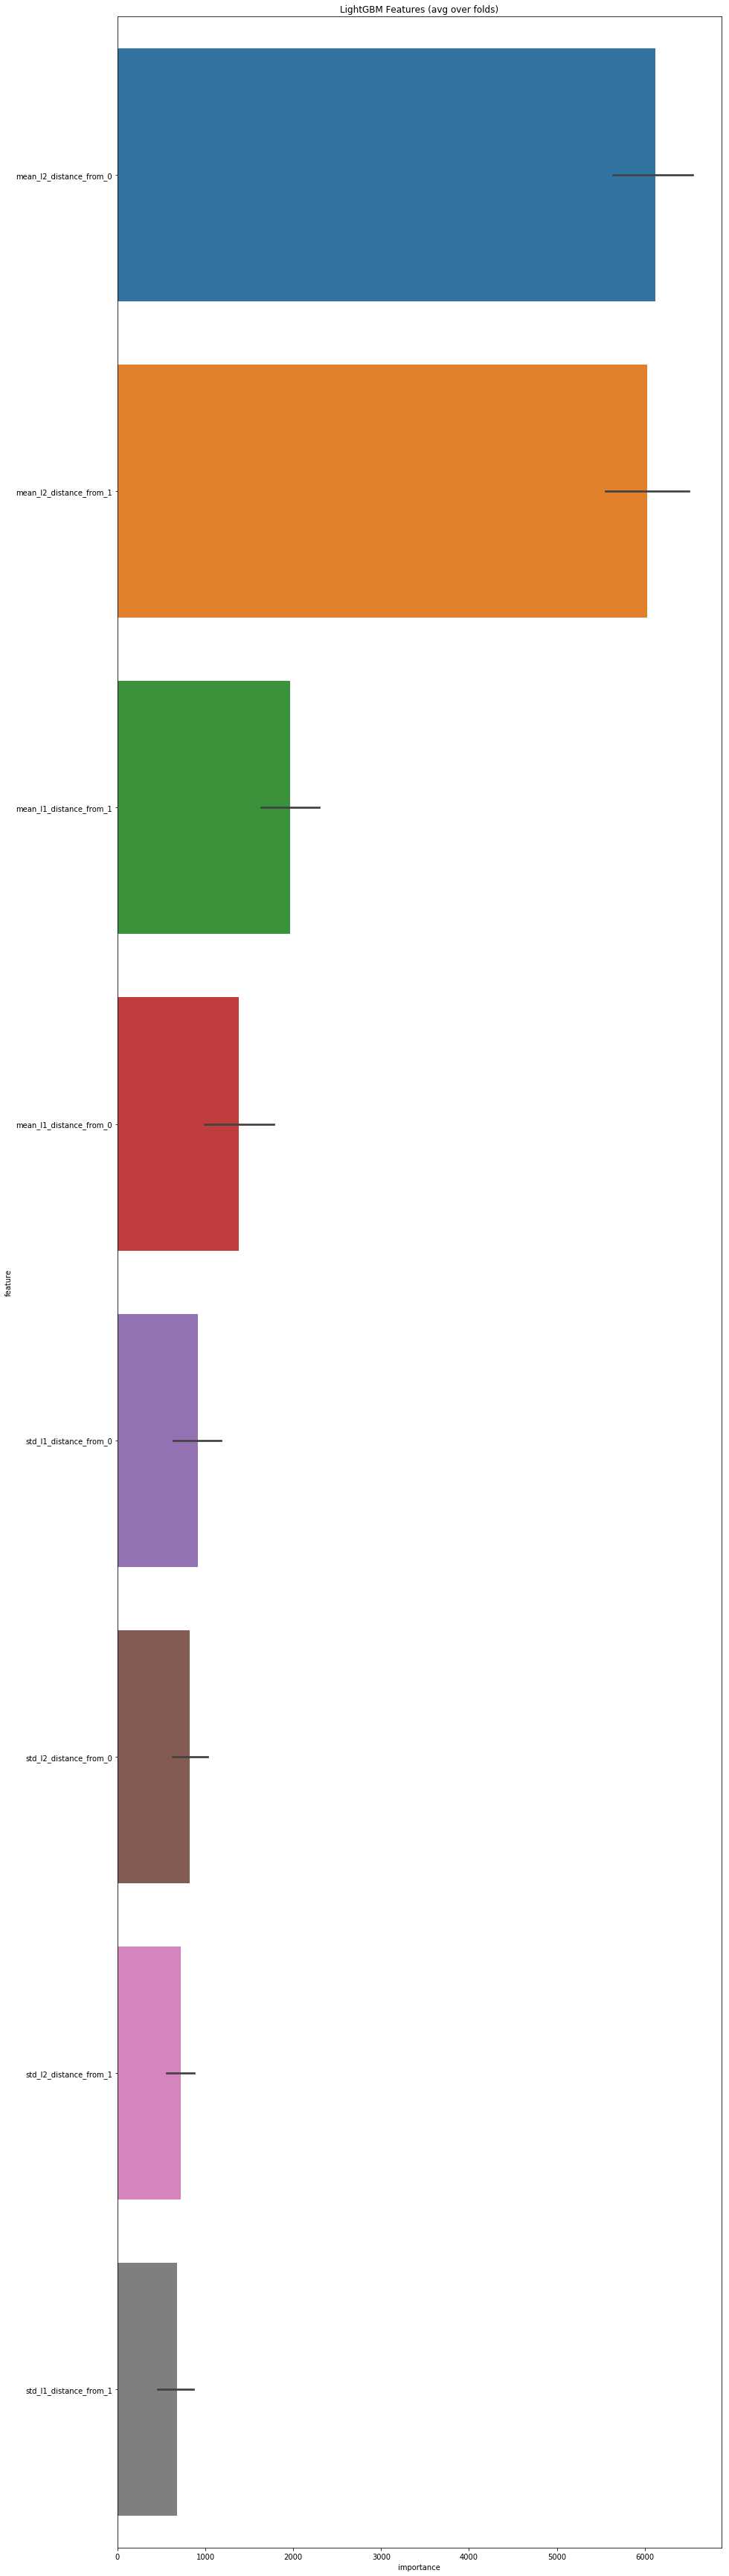

In [162]:
feature_importance_df['importance'] = feature_importance_df['importance'].astype('int')
ordered_feature = feature_importance_df.groupby(['feature'])['importance'].mean().sort_values(ascending=False).index
plt.figure(figsize=(12, 48))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
sns.barplot(x='importance', y='feature', data=feature_importance_df, order=ordered_feature)
plt.show()

In [147]:
submission = pd.read_csv(os.path.join(PATH, 'sample_submission.csv'))
submission['target'] = predictions
submission.to_csv(os.path.join('..', 'submission', '{}_lightgbm.csv'.format(str(datetime.datetime.today().date()).replace('-', ''))), index=False)

In [131]:
def cv_lightgbm(X, y, X_test, NFOLDS=5, SEED=2020):
    params_in_train = {
        'num_boost_round': 20000,
        'early_stopping_rounds': 200,
        'verbose_eval': 500,
    }

    skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

    oof = np.zeros(len(X))
    predictions = np.zeros(len(X_test))
    scores = {'train': [], 'valid': []}
    features = X.columns
    feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])

    for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
        print('fold: {}/{}'.format(fold+1, skf.n_splits))
        
        params = {
            'boosting': 'gbdt',
            'metric': 'auc',
            'objective': 'binary',
            'max_depth': 6,
            'num_leaves': 12,
            'min_data_in_leaf': 64,
            'bagging_freq': 5,
            'learning_rate': 0.01,
            'bagging_fraction': 0.4,
            'num_threads': cpu_count(),
            'verbose': -1,
            'seed': int(2**fold),
            'bagging_seed': int(2**fold),
            'drop_seed': int(2**fold),
        }
        
        dtrain = lgb.Dataset(X.iloc[train_index], label=y.iloc[train_index])
        dvalid = lgb.Dataset(X.iloc[valid_index], label=y.iloc[valid_index])
        
        model = lgb.train(params, dtrain, valid_sets=[dtrain, dvalid], **params_in_train)
        scores['train'].append(model.best_score['training']['auc'])
        scores['valid'].append(model.best_score['valid_1']['auc'])
        oof[valid_index] = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)

        fold_feature_importance_df = pd.DataFrame(columns=['fold', 'feature', 'importance'])
        fold_feature_importance_df['feature'] = features
        fold_feature_importance_df['importance'] = model.feature_importance()
        fold_feature_importance_df['fold'] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_feature_importance_df], axis=0)

        predictions += model.predict(X_test, num_iteration=model.best_iteration) / NFOLDS

        del model

    return oof, predictions, scores, feature_importance_df